Main Goals
---

For part 1: The main goal is to gain some experience with data processing issues as related to similarity assessment

For part 2: The main goal is to gain some experience with clustering of data. Explore algorithmic and search issues in both subject areas.

$1.$ Description of Available Data
---

Attached to this announcement please find the following files:

$$
\begin{array}{rll}
1. & \text{PIMA_Diabetes_2015}                       & \text{in ARFF format} \\
2. & \text{Training_Examples_TEXT_File1}             & \text{in text format} \\
3. & \text{Available_Distances_of_Pairs_of_Records1} & \text{in text format} \\
\end{array}
$$

The first file was retrieved from UCI's machine Learning Data Set Repository. It has all the data records available on that site. The second file is a random subset of the first data set (approximately of size $\frac{2}{3}$ of the original size). This data set (i.e. the second file) was used to form a number of random pairs of records (150 out of all possibilities). Some may be duplicates.

It is assumed that a panel of experts has examined each such pair and came up with a value that assesses in their collective opinion how close the two records are of each other. The closer they are, the more similar the corresponding records are assumed to be. For this study, such assessments have been <u>**simulated**</u> as follows.

A Euclidean distance was assumed to exist and then it was used on pairs of vectors to come up with these distance values. This Euclidean distance expresses a weighted sum of the squared differences of the attribute values of pairs of records.

This data set is defined on 9 attributes. The last one is the class attribute. For the purpose of this study please ignore the class attribute (which assumes binary value). Thus we have 8 attributes (all of which are numerical and ordinal). These values have been normalized by dividing the values of each attribute by the maximum value for that attribute. The values normalized as described above were next used in the "hidden" weighted Euclidean distance formula.

---

In [1]:
%matplotlib inline

In [2]:
import re
import numpy as np
from time import time

import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn import tree
import pydotplus

from IPython.display import clear_output, Image, display, Math, Latex

---

Read file #1: `PIMA_Diabetes_2015.ARFF`, the Pima Diabetes data set

In [3]:
with open('dm/PIMA_Diabetes_2015.ARFF') as pima_file:
    contents = pima_file.readlines()

In [4]:
attributes = [line.split()[1] for line in contents if line.startswith('@ATTRIBUTE')]
attributes.pop(-1)

data = [line for line in contents if line and not line.startswith(('%', '@', '\r', '\n'))]

In [5]:
Pima_Diabetes_Data = []
Pima_Diabetes_Target = []

for record in data:
    p = record.split(',')
    Pima_Diabetes_Data.append((
            int(p[0]),
            int(p[1]),
            int(p[2]),
            int(p[3]),
            int(p[4]),
            float(p[5]),
            float(p[6]),
            int(p[7]),
    ))
    Pima_Diabetes_Target.append(int(p[8]))

Pima_Diabetes_Data = np.array(Pima_Diabetes_Data)
Pima_Diabetes_Target = np.array(Pima_Diabetes_Target)
Pima_Feature_Names = [
    'Number of times pregnant',
    'Plasma glucose concentration (glucose tolerance test)',
    'Diastolic blood pressure (mm Hg)',
    'Triceps skin fold thickness (mm)',
    '2-Hour serum insulin (mu U/ml)',
    'Body mass index (weight in kg/(height in m)\^2)',
    'Diabetes pedigree function',
    'Age (years)'
]
Pima_Target_Names = np.array(['positive', 'negative'], 
      dtype='|S8')

Read file #2: `Training_Examples_TEXT_File1.txt`, the training examples file

In [6]:
Training_Examples = []

In [7]:
with open('dm/Training_Examples_TEXT_File1.txt') as training_file:
    data = training_file.readlines()

In [8]:
for record in data:
    p = record.split(',')
    Training_Examples.append((
            int(p[0]),
            int(p[1]),
            int(p[2]),
            int(p[3]),
            int(p[4]),
            float(p[5]),
            float(p[6]),
            int(p[7]),
    ))

Read file #3: `Available_Distances_of_Pairs_of_Records1.txt`, the distance pairs file

In [9]:
with open('dm/Available_Distances_of_Pairs_of_Records1.txt') as distances_file:
    contents = distances_file.readlines()

In [10]:
Available_Distances = []

In [11]:
pattern = re.compile(r' Pair No = ([-+]?\d+) First Record = ([-+]?\d+) Second Record = ([-+]?\d+) Distance = ([-+]?\d*\.\d+|\d+)\s*')

In [12]:
for line in contents:
    p = pattern.match(line)
    p = p.groups()
    Available_Distances.append((
            int(p[0]),
            int(p[1]),
            int(p[2]),
            float(p[3]),
    ))

In [13]:
Available_Distances[0]

(1, 153, 362, 0.195109293281901)

In [14]:
Training_Examples[0]

(9, 164, 78, 0, 0, 32.8, 0.148, 45)

$2.$ Tasks for Part 1 (On similarities)
---

Part 1 focuses on determining similarity values. For that you will have to first estimate the form of the Euclidean formula used to derive the values presented in the third file. In other words, you will have to use some type of search to estimate the weight values used in that formula. You may want to use a search method based on <u>**steepest descent**</u> as described in class. Once the "hidden" weighted Euclidean formula has been estimated, use it to determine similarity values between any pair of records from the second file.

In your report for part 1 you will have to present what the Euclidean formula you have derived (along with the weights used) and the values of the estimated distances of pairs described in the input file. Determine the total difference (say, expressed as the sum of all squared differences divided by the number ($=150$) of pairs)

---

The general form of a weighted Euclidean distance function is:
$$
d_{x_1 x_2} = \left( \sum\limits_{i=1}^{n}{ w_i ( x_{i_1} - x_{i_2} )^2 } \right)^\tfrac{1}{2}, \quad 0 \le w_i \le 1
$$

---

We know the training data was normalized by dividing its attribute value by the maximum value of that attribute to derive the training data but we do not have that information.

The Euclidean distance measure used must have looked like:
$$
d_{x_1 x_2} = \left( \sum\limits_{i=1}^{8}{w_i(x_{i_1}-x_{i_2})^2} \right)^\tfrac{1}{2}
$$

---

Let's normalize the values in Training_Examples

In [15]:
Training_Examples = np.array(Training_Examples)

In [16]:
Normalized_Examples = np.divide(Training_Examples, Training_Examples.max(axis = 0))

---

We randomly choose our starting point. To do so we generate 8 random numbers and normalize the results to get weights that cumulatively yield 1.

In [17]:
def random_starting_point():
    w = np.random.rand(8)
    w /= w.sum()
    return w

In [18]:
random_starting_point()

array([ 0.04671395,  0.06652313,  0.20963805,  0.08954534,  0.17261056,
        0.22420806,  0.02467463,  0.16608628])

In [19]:
def weighted_euclidean_distance(x_1, x_2, w):
    res = .0
    for i in range(8):
        res+= w[i] * (x_1[i] - x_2[i]) ** 2.0
    return np.sqrt(res)

Unit test for `weighted_euclidean_distance()`

In [20]:
Normalized_Examples[8]

array([ 0.11764706,  0.45728643,  0.50819672,  0.        ,  0.        ,
        0.40685544,  0.21694215,  0.27160494])

In [21]:
data = np.array([
        [   0.,     119.,       0.,       0.,       0.,      32.4,      0.141,   24.,   ],
        [  10.,     111.,      70.,      27.,       0.,      27.5,      0.141,   40.,   ],
        [   2.,      92.,      52.,       0.,       0.,      30.1,      0.141,   22.,   ],
    ])
weighted_euclidean_distance(
    x_1=np.array([0.52941176,0.8241206,0.63934426,0.,0.,0.48882265,0.06115702,0.55555556]),
    x_2=np.array([0.11764706,0.45728643,0.50819672,0.,0.,0.40685544,0.21694215,0.27160494]),
    w=np.array([0.04020281,0.08841431,0.08442112,0.06732131,0.01573263,0.51261337,0.10934525,0.08194919]),
)

0.18130426730743721

Let's test our distance function:

In [22]:
weighted_euclidean_distance(Normalized_Examples[0], Normalized_Examples[1], random_starting_point())

0.140837699757144

Let's see how far we are from values in Available_Distances

In [23]:
def calc_ms_error(weights, distances):
    ms_error = 0.0
    for record in distances:
        x_1 = Normalized_Examples[record[1]]
        x_2 = Normalized_Examples[record[2]]
        dist = weighted_euclidean_distance(x_1, x_2, weights)
        ms_error += np.power(dist - record[3], 2)
    return np.divide(ms_error, 150)

In [24]:
calc_ms_error(random_starting_point(), Available_Distances)

0.0096930598962415657

To choose the next group of weights we generate 4 random set of $\delta = \langle \delta_1, \delta_2, ..., \delta_8 \rangle, \; \sum\limits_{i=1}^{8}{\delta_i} = 0$ sets of weights and add them to current weights. If after 10,000 iterations no further better candidate is found then the search will be stopped.

In [25]:
def get_candidates(criteron, current_weights, distances, num_candidates = 4, stop_at = 100):
    start_time = time()
    res = []
    iterations_control = 0
    while len(res) <= num_candidates:
        iterations_control += 1
        # Generate 8 numbers (one per each attribute) between 0 and 1
        d = np.random.rand(8)        
        # Normalize the numbers to add up to zero
        d = d / d.sum() - .125
        
        w_candidate = d + current_weights
        
        # We want positive weights
        if np.all(w_candidate > 0):
            # Ensure the error decreases with these weights
            e = calc_ms_error(w_candidate, distances)
            if e < criteron:
                res += [(w_candidate, e)]
        if time() - start_time > stop_at:
            if res:
                return res
            raise ValueError
    return res

With all these pieces together let's perform steepest ascent search for 100 iterations and try to minimize the minimum squared error at each iteration, and its progress is which is depicted as a plot.

In [26]:
def plot_calc(mse, weights):
    def plot_mse(mse):
        plt.plot(mse)
        plt.xlabel('Number of iterations')
        plt.ylabel('MSE')
        plt.title('Minimum Squared Error')
        plt.grid()
    
    def plot_weights(weights):
        for a, h in weights.iteritems():
            plt.plot(h, label = a)
        plt.xlabel('Number of iterations')
        plt.ylabel('Attribute Weight')
        plt.title('Estimated Eclidean Distance Weights')
        plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
        plt.grid()
        
    plt.figure(figsize = (10, 10))
    plt.suptitle('Statistics for {} iterations'.format(len(mse)), fontsize = 14)
    
    plt.subplot(2, 1, 1)
    plot_mse(mse)
    
    plt.subplot(2, 1, 2)
    plot_weights(weights)
    
    plt.tight_layout()
    plt.subplots_adjust(top = 0.85)
    plt.show()

### Putting it altogether

Let's try running the search algorithm for a couple of iterations

In [27]:
def GRASP(weights, max_refinements = 40, stop_at = 100, mse = np.infty, mse_history = None, weight_history = None):
    # "max_iterations" iterations at most
    for i in range(max_refinements):
        # Get the list of candidates
        try:
            candidates = get_candidates(mse, weights, Available_Distances, stop_at = stop_at)
        except ValueError:
            return weights, i, mse_history, weight_history
        # Randomly choose a candidate
        weights, mse = candidates[np.random.randint(len(candidates))]

        # Add MSE and weights to the history
        if mse_history:
            mse_history += [mse]
        else:
            mse_history = [mse]
        for i, attr in enumerate(attributes):
            if weight_history:
                if weight_history.has_key(attr):
                    weight_history[attr] += [weights[i]]
                else:
                    weight_history[attr] = [weights[i]]
            else:
                weight_history = {
                    attr: weights[i]
                }
        
        # Plot the updated values
        clear_output(wait = True)
        plot_calc(mse_history, weight_history)
    return weights, i, mse_history, weight_history

In [28]:
def display_weights(w):
    display(Math(r'''
        d_{{x_1 x_2}} \approx
        \left(
            \begin{{array}}{{ll}}
                & ({0}) x_1 \\
              + & ({1}) x_2 \\
              + & ({2}) x_3 \\
              + & ({3}) x_4 \\
              + & ({4}) x_5 \\
              + & ({5}) x_6 \\
              + & ({6}) x_7 \\
              + & ({7}) x_8 \\
            \end{{array}}
        \right)^{{\tfrac{{1}}{{2}}}}
        '''.format(*w)))

In [29]:
estimations = []

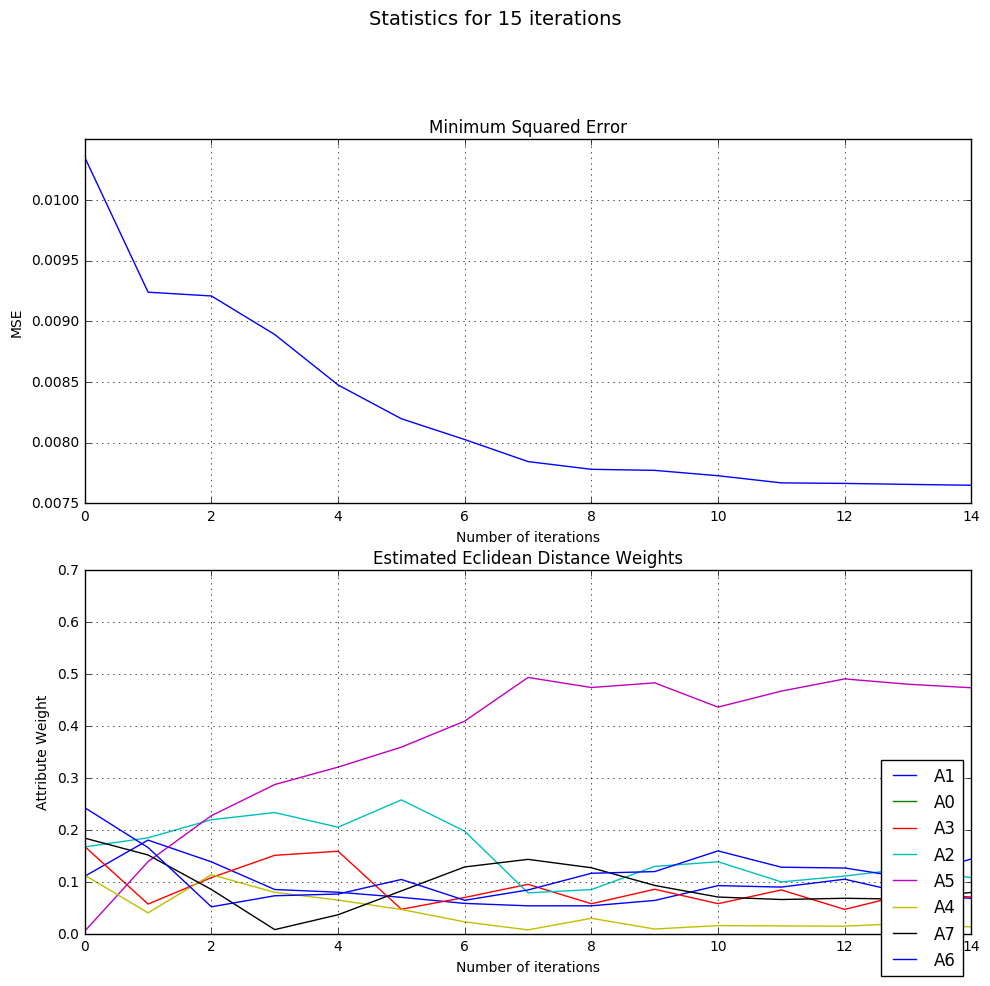

GRASP terminated after 15 iterations.


<IPython.core.display.Math object>

In [30]:
max_refinements = 40
estimate, num_refinements, e_history, w_history = GRASP(
    random_starting_point(),
    max_refinements = max_refinements,
    stop_at = 60
)

if num_refinements < max_refinements:
    print 'GRASP terminated after {} iterations.'.format(num_refinements)

display_weights(estimate)
estimations += [estimate]

In [31]:
for w in estimations:
    display_weights(w)

<IPython.core.display.Math object>

$3.$ Tasks for Part 2 (On Clustering)
---

Part 2 focuses on clustering. Thus, once you have estimated the "hidden" weighted Euclidean formula used in Part 1 to determine the distance values, use it to cluster the data described in the second file. The number of clusters of the proposed clustering scheme is up to you to decide.

In your report for Part 2 you will have to describe what objective function you tried to optimize in your clustering scheme. You may have to present and analyze a number of alternative clustering schemes and then describe and explain which one is the best one. For clustering data you can use any one of the methods we used in class.

---

Partition Purity Measures
---
If $p(i|t)$ denotes the fraction of items belonging to class $i$ at node $t$ and $c$ denotes the number of classes then we can use the following measures of to observe purity of partitions:

$$
\begin{array}{rcl}
\operatorname{Entropy(t)} & = & -\sum\limits_{i=0}^{c-1}{p(i|t)\log_2{p(i|t)}} \\[2ex]
\operatorname{Gini Index} & = & 1-\sum\limits_{i=0}^{c-1}{[p(i|t)]^2} \\[2ex]
\operatorname{Classification Error} & = & 1-\max_i{p(i|t)} \\
\end{array}
$$

Entropy can be implemented as follows:

In [32]:
def entropy(data, target_attr):
    data_entropy = 0.

    # Frequency of each of value in target_attr
    val_freq = np.array(np.unique(data[:, target_attr], return_counts=True)[1])

    # Entropy of data for target_attr
    p_it = val_freq.astype(float) / data.shape[0]
    data_entropy = np.nansum(-p_it * np.log2(p_it))
    
    return data_entropy

To Determine the quality of test conditions based on one of the impurity measures at child node $v_j$, denoted as $I(\cdot)$, we would like to maximize $\Delta_{\operatorname{info}}$, information gain, which is defined as:

$$
\Delta = I(\text{parent}) - \sum\limits_{j=1}^{k}{\dfrac{N(v_j)}{N}I(v_j)}
$$

Where $k$ is the number of attributes and $N(\cdot)$ represents the number of records associated with a node.

In [33]:
def gain(data, attr, target_attr):
    subset_entropy = 0.

    # Frequency of each of value in target_attr
    vals, val_freq = np.unique(data[:, attr], return_counts=True)

    # Calculate the sum of the entropy for each subset of records weighted
    # by their probability of occuring in the training set.
    sum_records = float(sum(val_freq))
    for i in range(len(vals)):
        val, freq = vals[i], val_freq[i]
        val_prob = freq / sum_records
        data_subset = data[data[:, attr] == val]
        i_ent = entropy(data_subset, target_attr)
        subset_entropy += val_prob * i_ent

    # Subtract the entropy of the chosen attribute from the entropy of the
    # whole data set with respect to the target attribute (and return it)
    return (entropy(data, target_attr) - subset_entropy)

Unit test for gain

In [34]:
data = np.array([
        [   0.,     119.,       0.,       0.,       0.,      32.4,      0.141,   24.,   ],
        [  10.,     111.,      70.,      27.,       0.,      27.5,      0.141,   40.,   ],
        [   2.,      92.,      52.,       0.,       0.,      30.1,      0.141,   22.,   ],
    ])
gain(data, attr=2, target_attr=7)

1.5849625007211561

However, instead of using gain, $\Delta$, that is typically used in decision trees, based on the idea proposed by [[Liu et all]](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5497736), I decided to use our weighted Euclidean distance function and use <u>*average weighted Euclidean distance*</u> for purity measurement.

Assuming $D$ is the dataser $A$ is an attribute, $i$ is an iterator for each record in $D$, $j$ is an iterator for each class:

$$
    \operatorname{AED}(A) = \frac{\sqrt{\sum\limits_{i=1}^{n}{(\, x_{i1} - x_{i2} \,)^2}}}{n}
$$

> Reference:

> Liu, Quan, Daojing Hu, and Qicui Yan. "Decision tree algorithm based on average Euclidean distance." *Future Computer and Communication (ICFCC), 2010 2nd International Conference on. Vol. 1. IEEE, 2010.*

In [35]:
def ae_distance(data, attr, target_attr):
    def _ae_distance(data, attr, w):
        ws = data.sum(axis=0)
        t = (w * data ** 2.0)
        tt = t[:, attr] / ws[attr]
        return tt.sum()

    averaging_weights = estimations[0]

    subset_distance = _ae_distance(data, attr, averaging_weights)
    target_distance = _ae_distance(data, target_attr, averaging_weights)

    return (subset_distance - target_distance)

Unit test for ae_distance

In [36]:
data = np.array([
        [   0.,     119.,       0.,       0.,       0.,      32.4,      0.141,   24.,   ],
        [  10.,     111.,      70.,      27.,       0.,      27.5,      0.141,   40.,   ],
        [   2.,      92.,      52.,       0.,       0.,      30.1,      0.141,   22.,   ],
    ])
ae_distance(data, attr=2, target_attr=7)

4.2798163138276522

```python
# Example weights:
w =
array([ 0.03884355,  0.09437358,  0.0874599 ,  0.05884017,  0.0067347 ,
        0.50965664,  0.13201275,  0.07207871])
```

We choose the next attribute, which is the attribute with the highest information gain (lowest entropy).

In [37]:
def choose_attribute(data, attributes, target_attr, fit_fx):
    best_gain = -np.inf
    best_attr = None

    for attr in attributes:
        gain = fit_fx(data, attr, target_attr)

        if (gain >= best_gain and attr != target_attr):
            best_gain = gain
            best_attr = attr

    if best_attr is None:
        print 'data', data.shape, 'attributes', repr(attributes), 'target_attr', repr(target_attr)
        print 'data\n', repr(data)
        raise ValueError
    return best_attr

Unit test for `choose_attribute()`

In [38]:
#data (2, 8)
choose_attribute(
    data=np.array([
        [  13.   ,  106.   ,   70.   ,    0.   ,    0.   ,   34.2  ,    0.251,   52.   ],
        [   1.   ,  106.   ,   70.   ,   28.   ,  135.   ,   34.2  ,    0.142,   22.   ]
    ]),
    attributes=[0, 3, 4, 6, 7],
    target_attr=7,
    fit_fx=ae_distance,
)

3

Decision Tree Implementation
---

The decision tree algorithm can be implemented as follows:

In [39]:
def make_decision_tree(data, attrs, target, fit_fx):
    # If dataset's empty or no attributes are left
    if np.all(data == 0) or len(attrs) <= 1:
        return vals[0]
    
    data = data.copy()
    vals = data[:, target]
    
    unique_vals, val_freq = np.unique(vals, return_counts = True)
    
    # If all data belongs to the same attribute
    if np.sum(vals == vals[0]) == vals.shape[0]:
        default = unique_vals[np.argmax(val_freq)]
        return default
    
    
    # Choose the next best attribute to best classify our data
    best = choose_attribute(
        data, attrs, target, fit_fx
    )

    tree = { best: {} }

    other_attrs = attrs[:]
    
    other_attrs.remove(best)

    possible_values = np.unique(data[:, best])

    np.delete(data, best, axis = 1)
    # For each of the values in best attribute field
    for val in possible_values:
        subtree = make_decision_tree(
            data[data[:, best] == val],
            other_attrs,
            target,
            fit_fx)

        # Add the new subtree to the empty dictionary object in our new tree/node we just created.
        tree[best][val] = subtree
    return tree

In [40]:
def print_tree(tree, str=''):
    """
    This function recursively crawls through the d-tree and prints it out in a
    more readable format than a straight print of the Python dict object.  
    """
    if type(tree) == dict:
        print "%s%s" % (str, tree.keys()[0])
        for item in tree.values()[0].keys():
            print "%s\t%s" % (str, item)
            print_tree(tree.values()[0][item], str + "\t")
    else:
        print "%s\t->\t%s" % (str, tree)

In [41]:
Pima_Tree_Gain = make_decision_tree(Training_Examples, list(range(len(attributes))), len(attributes) - 1, gain)

In [42]:
Pima_Tree_AE = make_decision_tree(Training_Examples, list(range(len(attributes))), len(attributes) - 1, ae_distance)

/home/pamini/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


In [43]:
print_tree(Pima_Tree_AE)

5
	0.0
	2
		0.0
		1
			114.0
				->	26.0
			115.0
				->	30.0
			84.0
				->	21.0
			94.0
				->	25.0
		64.0
			->	21.0
		82.0
			->	69.0
	19.5
	2
		74.0
			->	28.0
		62.0
			->	25.0
	46.2
		->	46.0
	22.5
	2
		56.0
			->	22.0
		96.0
			->	21.0
	19.4
		->	22.0
	42.4
		->	29.0
	45.8
		->	31.0
	32.4
	1
		128.0
			->	27.0
		132.0
			->	21.0
		133.0
			->	37.0
		108.0
			->	42.0
		141.0
			->	22.0
		110.0
			->	27.0
		142.0
			->	63.0
		119.0
			->	24.0
		154.0
			->	45.0
		91.0
			->	27.0
	22.4
	2
		122.0
			->	27.0
		44.0
			->	22.0
	21.0
	1
		101.0
			->	21.0
		150.0
			->	37.0
	34.1
	1
		112.0
			->	26.0
		123.0
			->	28.0
		181.0
			->	38.0
	23.0
		->	40.0
	24.0
	1
		111.0
			->	23.0
		108.0
			->	35.0
		103.0
			->	33.0
	25.0
	2
		78.0
			->	64.0
		60.0
			->	27.0
		70.0
			->	25.0
		62.0
			->	36.0
	26.0
	1
		136.0
			->	51.0
		110.0
			->	30.0
	27.0
		->	36.0
	28.0
	1
		129.0
			->	27.0
		146.0
			->	29.0
		132.0
			->	63.0
	29.0
	1
		106.0
			->	22.0
		119.0
			->	29.0
	30.0
	1
		8

In [44]:
clf = tree.DecisionTreeClassifier()
cf = clf.fit(Pima_Diabetes_Data, Pima_Diabetes_Target)

In [55]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=Pima_Feature_Names,
    class_names=Pima_Target_Names,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data)

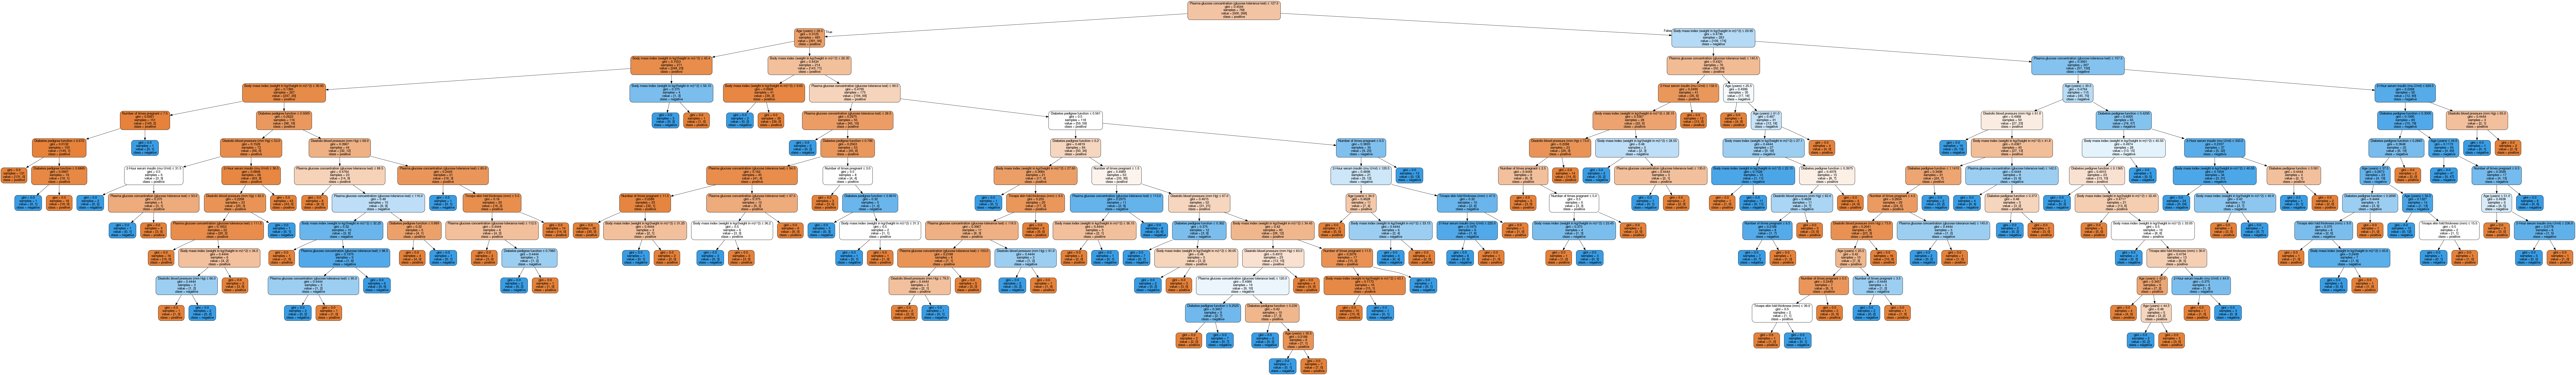

In [56]:
#Image(graph.create_svg())
Image(graph.create_png())

---

### Note

I dropped the K-means solution, since I could not come up with a meaningful interpretations of the results. Futher progress and refactoring in this project may have broken the K-means clustering code.

In [46]:
# Calculates euclidean distance between
# a data point and all the available cluster
# centroids.      
def euclidean_dist(data, centroids, clusters):
    for instance in data:  
        # Find which centroid is the closest
        # to the given data point.
        mu_index = min(
            [
                (
                    i[0],
                    np.linalg.norm(instance - centroids[i[0]])
                ) for i in enumerate(centroids)
            ],
            key = lambda t:t[1]
        )[0]
        try:
            clusters[mu_index] += [instance]
        except KeyError:
            clusters[mu_index] = [instance]

    # If any cluster is empty then assign one point
    # from data set randomly so as to not have empty
    # clusters and 0 means.        
    for cluster in clusters:
        if not cluster:
            cluster.append(
                data[
                    np.random.randint(0, len(data), size = 1)
                ].flatten().tolist()
            )
    return clusters

In [47]:
# randomize initial centroids
def randomize_centroids(data, centroids, k):
    for cluster in range(0, k):
        centroids.append(data[np.random.randint(0, len(data), size=1)].flatten().tolist())
    return centroids

In [48]:
# check if clusters have converged    
def has_converged(centroids, old_centroids, iterations):
    MAX_ITERATIONS = 1000
    if iterations > MAX_ITERATIONS:
        return True
    return old_centroids == centroids

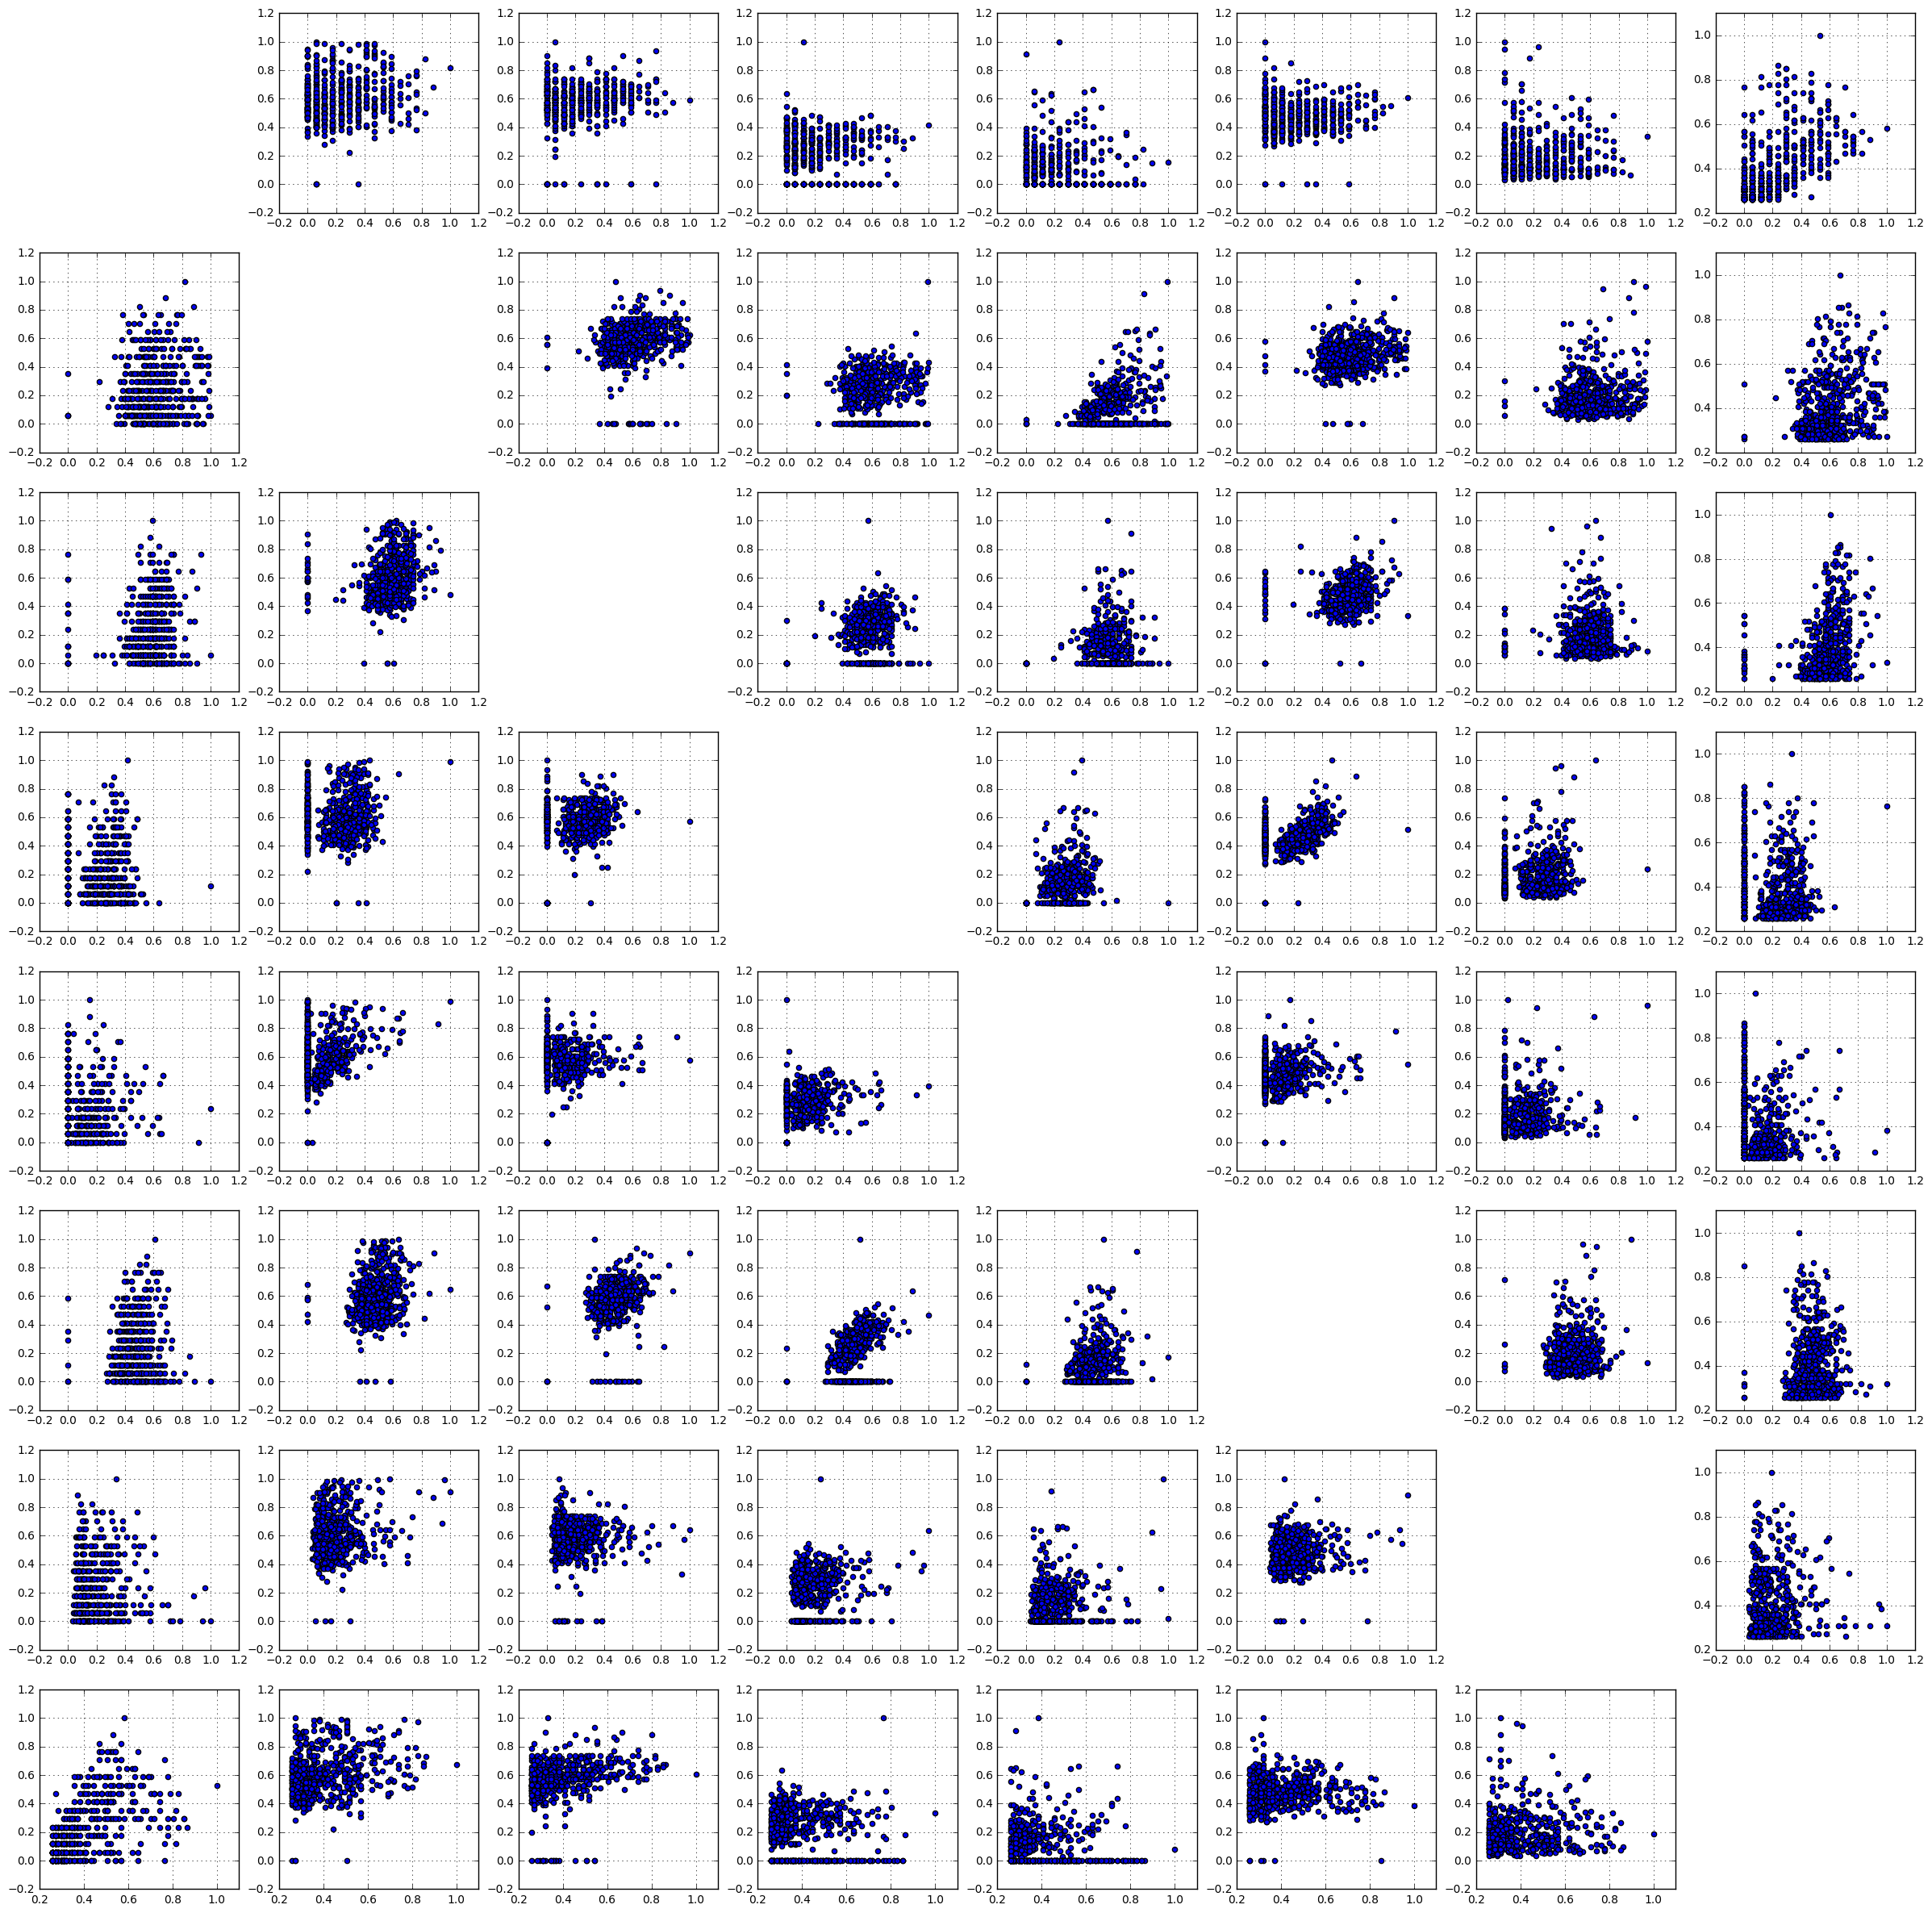

In [49]:
plt.figure(figsize = (30, 30))
for i in range(8):
    for j in range(8):
        if i != j:
            plot_id = i * 8 + j + 1
            plt.subplot(8, 8, plot_id)
            plt.scatter(Normalized_Examples[:, i], Normalized_Examples[:, j])
            plt.grid()
        
plt.show()

In [50]:
# kmeans clustering algorithm
# data = set of data points
# k = number of clusters
def k_means(data, k):
    centroids = []

    centroids = randomize_centroids(data, centroids, k)  

    old_centroids = [[] for i in range(k)] 

    iterations = 0
    while not (has_converged(centroids, old_centroids, iterations)):
        iterations += 1

        clusters = [[] for i in range(k)]

        # Assign data points to clusters
        clusters = euclidean_dist(data, centroids, clusters)

        # Recalculate centroids
        index = 0
        for cluster in clusters:
            old_centroids[index] = centroids[index]
            centroids[index] = np.mean(cluster, axis=0).tolist()
            index += 1


    print("The total number of data instances is: " + str(len(data)))
    print("The total number of iterations necessary is: " + str(iterations))
    print("The means of each cluster are: " + str(centroids))
    print("The clusters are as follows:")
    for cluster in clusters:
        print("Cluster with a size of " + str(len(cluster)) + " starts here:")
        print(np.array(cluster).tolist())
        print("Cluster ends here.")

    return np.array(cluster).tolist()

In [51]:
a = k_means(Training_Examples, 5)

The total number of data instances is: 514
The total number of iterations necessary is: 24
The means of each cluster are: [[3.9887005649717513, 95.46327683615819, 64.57062146892656, 14.338983050847459, 9.305084745762711, 29.476836158192093, 0.40992090395480246, 31.35593220338983], [2.962406015037594, 117.05263157894737, 69.83458646616542, 28.18045112781955, 105.66165413533835, 32.38721804511278, 0.4849473684210527, 29.24812030075188], [4.235294117647059, 156.76470588235293, 72.23529411764706, 33.35294117647059, 465.05882352941177, 35.96470588235293, 0.6399411764705885, 32.588235294117645], [3.5921052631578947, 138.07894736842104, 73.21052631578948, 30.026315789473685, 217.46052631578948, 34.596052631578964, 0.586342105263158, 33.48684210526316], [4.837837837837838, 149.36036036036037, 74.57657657657657, 11.36936936936937, 0.5855855855855856, 33.310810810810814, 0.473801801801802, 40.0990990990991]]
The clusters are as follows:
Cluster with a size of 177 starts here:
[[1.0, 79.0, 60.0, 

In [52]:
for i in a:
    print i

[9.0, 164.0, 78.0, 0.0, 0.0, 32.8, 0.148, 45.0]
[4.0, 134.0, 72.0, 0.0, 0.0, 23.8, 0.277, 60.0]
[7.0, 147.0, 76.0, 0.0, 0.0, 39.4, 0.257, 43.0]
[9.0, 164.0, 84.0, 21.0, 0.0, 30.8, 0.831, 32.0]
[4.0, 136.0, 70.0, 0.0, 0.0, 31.2, 1.182, 22.0]
[5.0, 128.0, 80.0, 0.0, 0.0, 34.6, 0.144, 45.0]
[1.0, 199.0, 76.0, 43.0, 0.0, 42.9, 1.394, 22.0]
[0.0, 147.0, 85.0, 54.0, 0.0, 42.8, 0.375, 24.0]
[2.0, 197.0, 70.0, 99.0, 0.0, 34.7, 0.575, 62.0]
[4.0, 145.0, 82.0, 18.0, 0.0, 32.5, 0.235, 70.0]
[2.0, 128.0, 64.0, 42.0, 0.0, 40.0, 1.101, 24.0]
[0.0, 180.0, 66.0, 39.0, 0.0, 42.0, 1.893, 25.0]
[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0]
[0.0, 123.0, 72.0, 0.0, 0.0, 36.3, 0.258, 52.0]
[5.0, 147.0, 75.0, 0.0, 0.0, 29.9, 0.434, 28.0]
[7.0, 178.0, 84.0, 0.0, 0.0, 39.9, 0.331, 41.0]
[10.0, 122.0, 78.0, 31.0, 0.0, 27.6, 0.512, 45.0]
[6.0, 124.0, 72.0, 0.0, 0.0, 27.6, 0.368, 29.0]
[3.0, 150.0, 76.0, 0.0, 0.0, 21.0, 0.207, 37.0]
[1.0, 124.0, 74.0, 36.0, 0.0, 27.8, 0.1, 30.0]
[9.0, 184.0, 85.0, 15.0, 0.0, 3

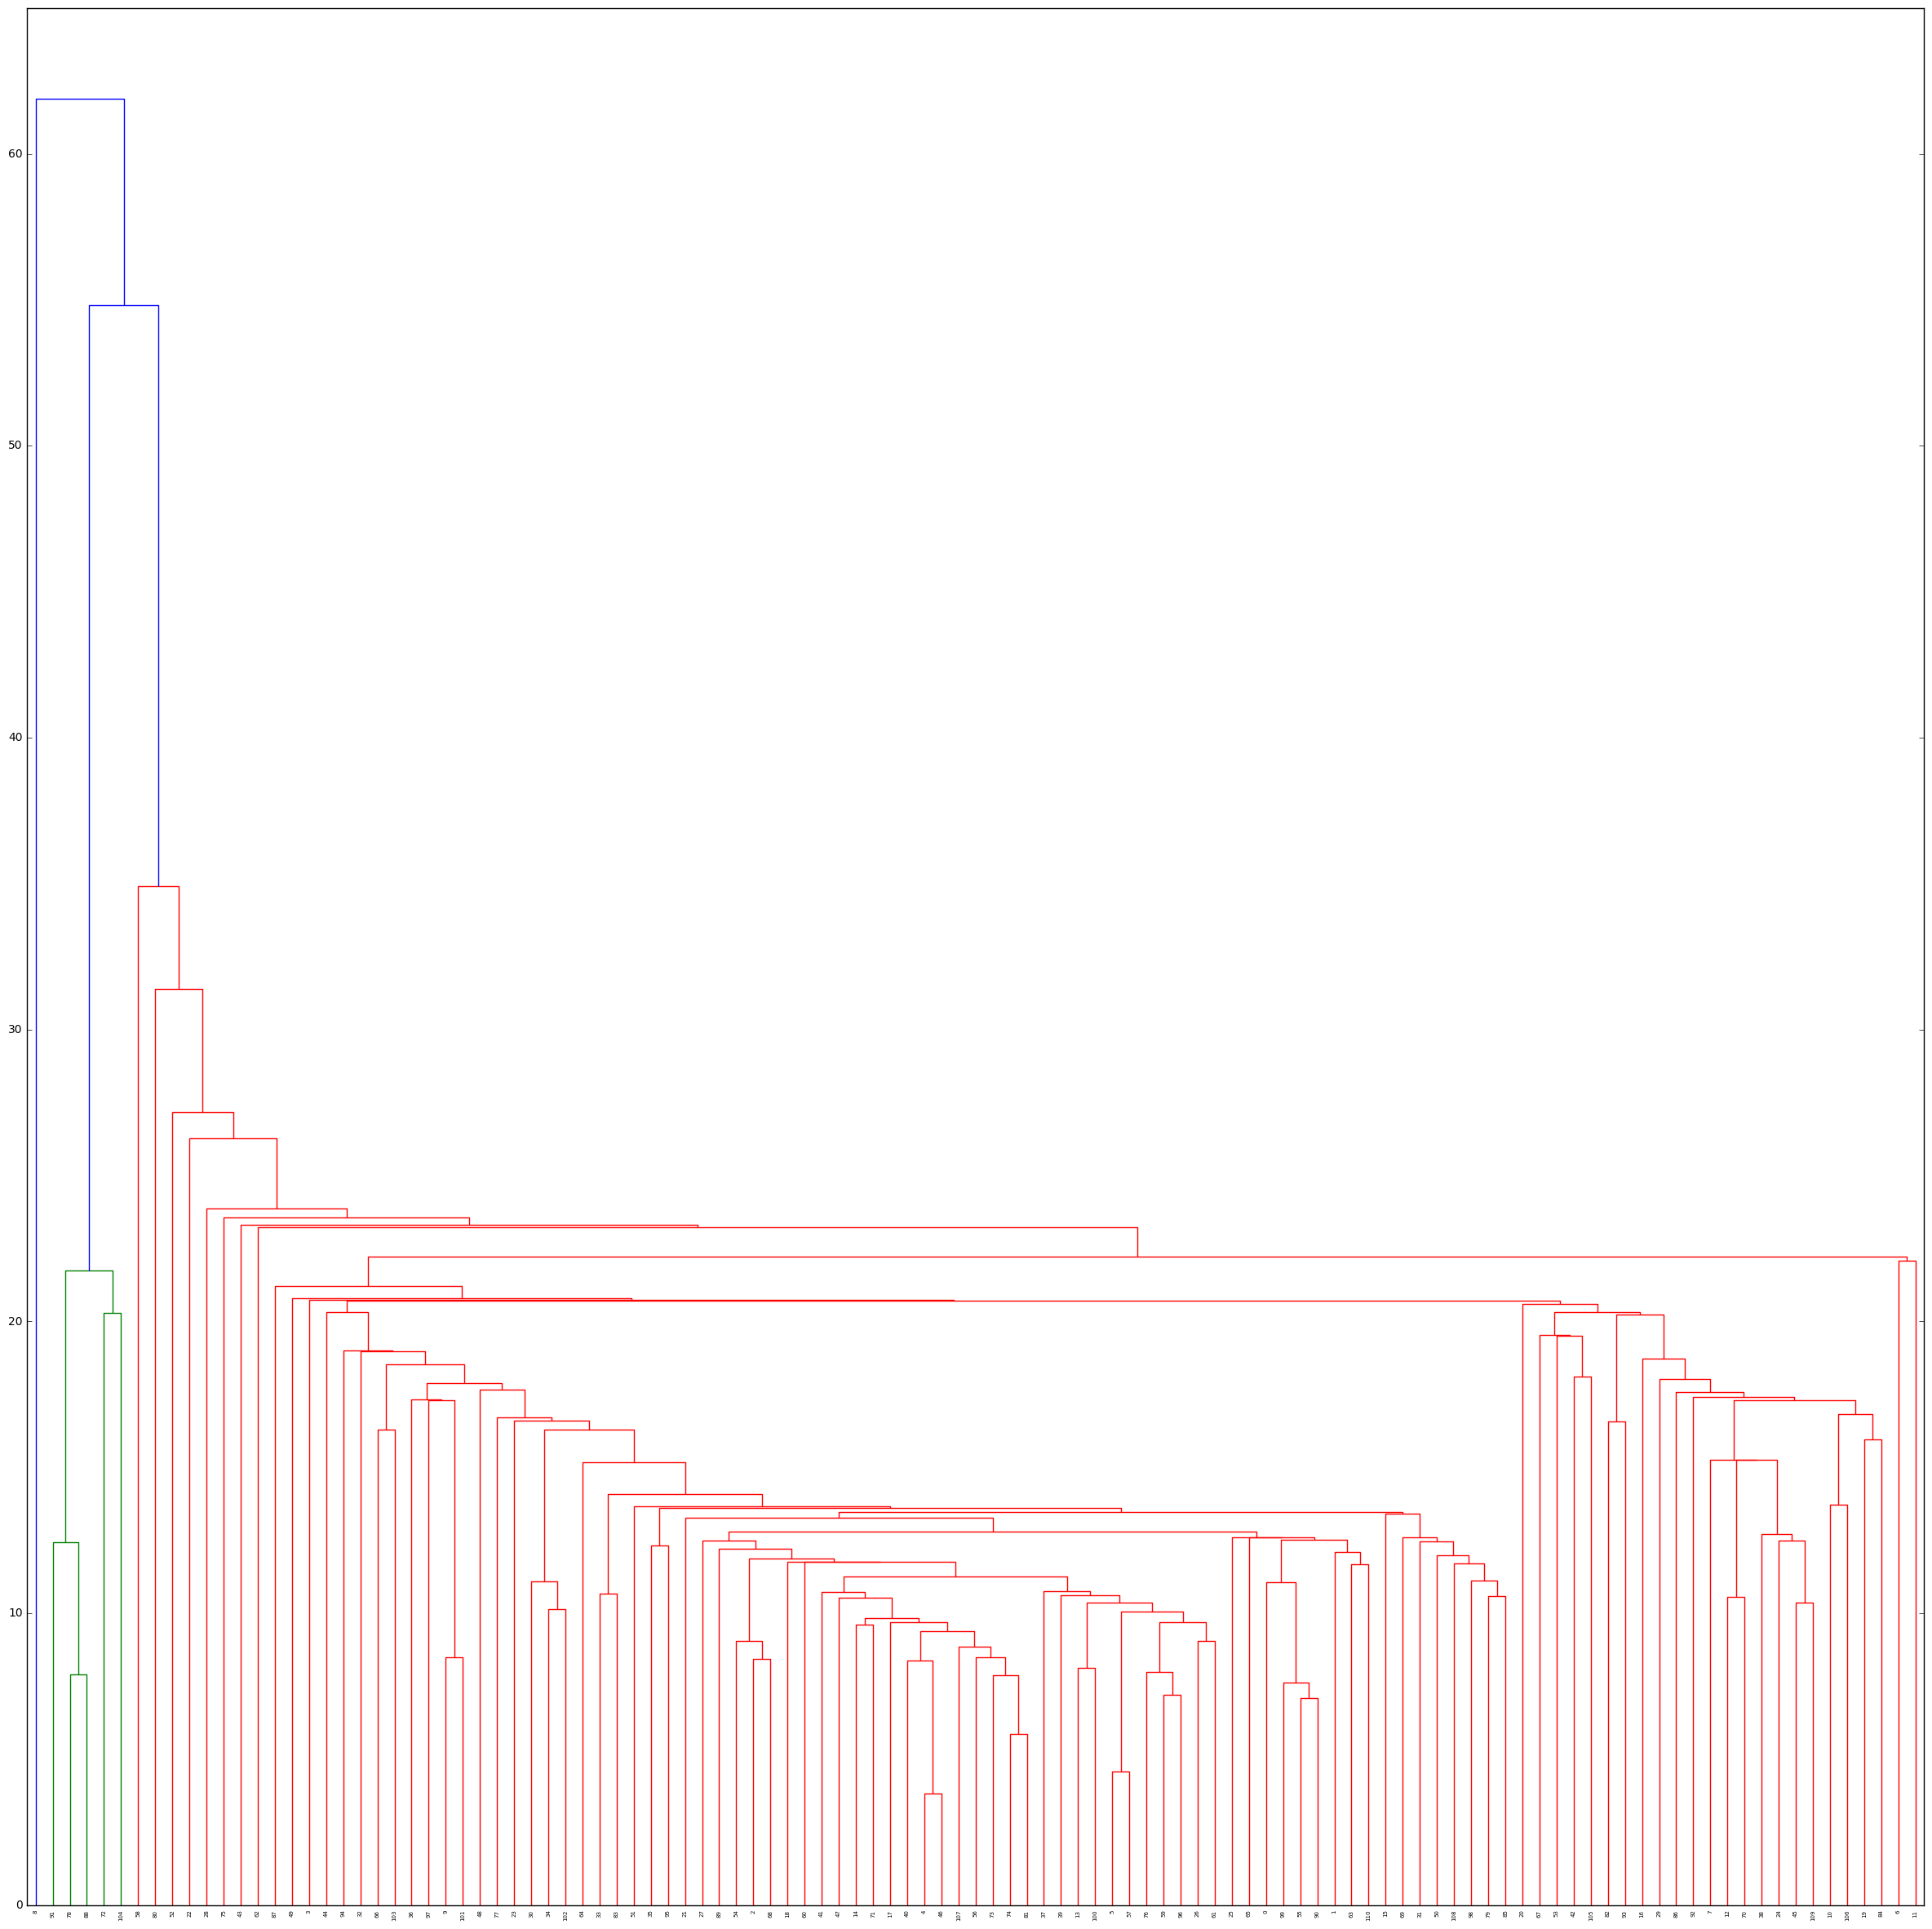

In [53]:
plt.figure(figsize = (30, 30))
cc = hierarchy.linkage(a)
hierarchy.dendrogram(cc)
plt.show()

Let's perform $K$-Means clustering on this data.

The objective function in $K$-Means clustering scheme is:
$$
J = \sum\limits_{j=1}^{k}{\sum\limits_{i=1}^{n}{|| x_i^{(j)} - c_j ||^2}}
$$

The procedure for finding $K$-Means consists of:
1. Choose $K$ random points as the initial group centroids.
2. Each object is assigned to the group with the closest centroid.
3. Recalculate the positions of the $K$ centroids after all objects are assigned.
4. If the stop condition is met, which is when centroids no longer move, then we have finished. Otherwise goto step 2.

Note: $K$-Means clustering is very sensitive to the initial randomly selected cluster centers. Performing the algorithm several times may alleviate this issue.

<u>**Attach this form on front of your answers.**</u>